In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# Load the data
mouse_metadata = pd.read_csv("mouse_metadata.csv")
study_results = pd.read_csv("study_results.csv")

# Merge the dataframes
merged_data = pd.merge(mouse_metadata, study_results, on="Mouse ID", how="outer")

# Display the number of unique mice IDs
unique_mice_count = merged_data["Mouse ID"].nunique()
print("Number of unique mice IDs:", unique_mice_count)

# Check for mouse IDs with duplicate time points
duplicate_mouse_ids = merged_data[merged_data.duplicated(subset=["Mouse ID", "Timepoint"])]["Mouse ID"].unique()
print("Mouse IDs with duplicate time points:", duplicate_mouse_ids)

# Display the data associated with the mouse ID with duplicate time points
if len(duplicate_mouse_ids) > 0:
    print("\nData associated with the mouse ID with duplicate time points:")
    print(merged_data[merged_data["Mouse ID"].isin(duplicate_mouse_ids)])

    # Create a new DataFrame where data associated with the mouse ID with duplicate time points is removed
    cleaned_data = merged_data[~merged_data["Mouse ID"].isin(duplicate_mouse_ids)]
    print("\nCleaned DataFrame:")
    print(cleaned_data)
else:
    cleaned_data = merged_data

# Display the updated number of unique mice IDs
updated_unique_mice_count = cleaned_data["Mouse ID"].nunique()
print("\nUpdated number of unique mice IDs after cleaning:", updated_unique_mice_count)

# Generate Summary Statistics
summary_statistics = cleaned_data.describe()
print("\nSummary Statistics:")
print(summary_statistics)

Number of unique mice IDs: 249
Mouse IDs with duplicate time points: ['g989']

Data associated with the mouse ID with duplicate time points:
    Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
908     g989     Propriva  Female          21          26          0   
909     g989     Propriva  Female          21          26          0   
910     g989     Propriva  Female          21          26          5   
911     g989     Propriva  Female          21          26          5   
912     g989     Propriva  Female          21          26         10   
913     g989     Propriva  Female          21          26         10   
914     g989     Propriva  Female          21          26         15   
915     g989     Propriva  Female          21          26         15   
916     g989     Propriva  Female          21          26         20   
917     g989     Propriva  Female          21          26         20   
918     g989     Propriva  Female          21          26         2

In [2]:
# Define aggregation functions and column names
aggregations = {
    "mean": "mean",
    "median": "median",
    "variance": "var",
    "standard_deviation": "std",
    "SEM": "sem"
}

# Calculate statistics for each drug regimen
summary_statistics = merged_data.groupby("Drug Regimen")["Tumor Volume (mm3)"].agg(**aggregations)

# Display the summary statistics DataFrame
print("\nSummary Statistics:")
print(summary_statistics)


Summary Statistics:
                   mean     median   variance  standard_deviation       SEM
Drug Regimen                                                               
Capomulin     40.675741  41.557809  24.947764            4.994774  0.329346
Ceftamin      52.591172  51.776157  39.290177            6.268188  0.469821
Infubinol     52.884795  51.820584  43.128684            6.567243  0.492236
Ketapril      55.235638  53.698743  68.553577            8.279709  0.603860
Naftisol      54.331565  52.509285  66.173479            8.134708  0.596466
Placebo       54.033581  52.288934  61.168083            7.821003  0.581331
Propriva      52.322552  50.854632  42.351070            6.507770  0.512884
Ramicane      40.216745  40.673236  23.486704            4.846308  0.320955
Stelasyn      54.233149  52.431737  59.450562            7.710419  0.573111
Zoniferol     53.236507  51.818479  48.533355            6.966589  0.516398


<Axes: title={'center': 'Total Number of Rows per Drug Regimen (Pandas)'}, xlabel='Drug Regimen', ylabel='Number of Rows'>

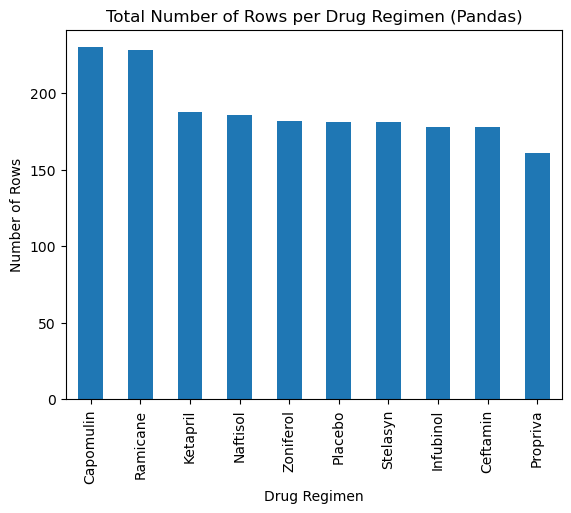

In [3]:
# Calculate total number of rows for each drug regimen
drug_regimen_counts = merged_data["Drug Regimen"].value_counts()

# Create the first bar chart with Pandas DataFrame.plot() method
drug_regimen_counts.plot(kind="bar", xlabel="Drug Regimen", ylabel="Number of Rows", title="Total Number of Rows per Drug Regimen (Pandas)")


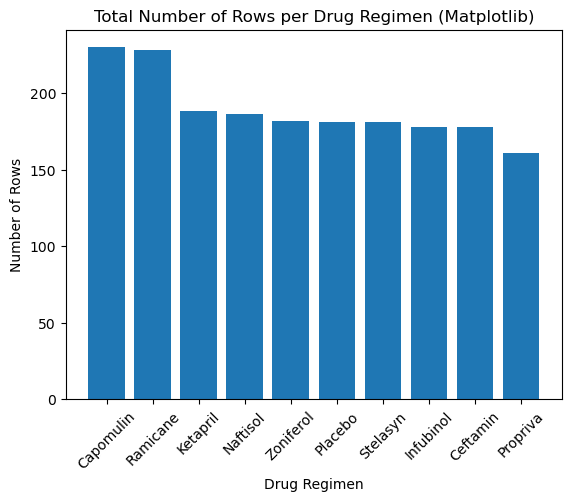

In [4]:
# Create the second bar chart with Matplotlib's pyplot methods
plt.bar(drug_regimen_counts.index, drug_regimen_counts.values)
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Rows")
plt.title("Total Number of Rows per Drug Regimen (Matplotlib)")
plt.xticks(rotation=45)
plt.show()

<Axes: title={'center': 'Distribution of Female vs Male Mice (Pandas)'}, ylabel='count'>

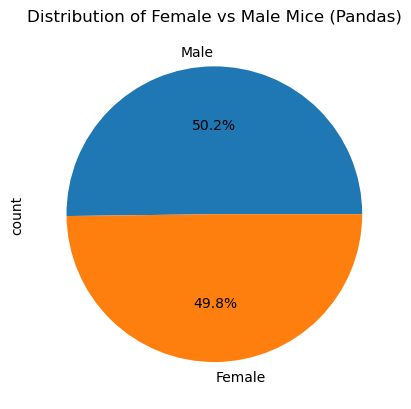

In [5]:
# Calculate distribution of female versus male mice
gender_distribution = mouse_metadata["Sex"].value_counts()

# Create the first pie chart with Pandas DataFrame.plot() method
gender_distribution.plot(kind="pie", autopct="%1.1f%%", title="Distribution of Female vs Male Mice (Pandas)")

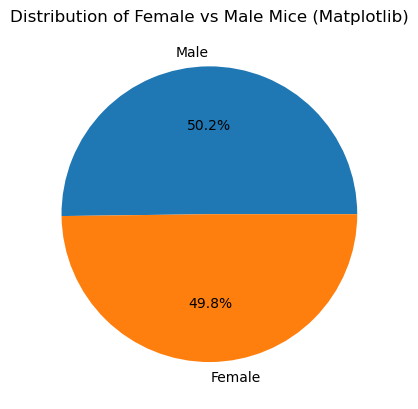

In [6]:
# Create the second pie chart with Matplotlib's pyplot methods
plt.pie(gender_distribution, labels=gender_distribution.index, autopct="%1.1f%%")
plt.title("Distribution of Female vs Male Mice (Matplotlib)")
plt.show()

Potential outliers for Capomulin: Series([], Name: Tumor Volume (mm3), dtype: float64)
Potential outliers for Ramicane: Series([], Name: Tumor Volume (mm3), dtype: float64)
Potential outliers for Infubinol: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Potential outliers for Ceftamin: Series([], Name: Tumor Volume (mm3), dtype: float64)


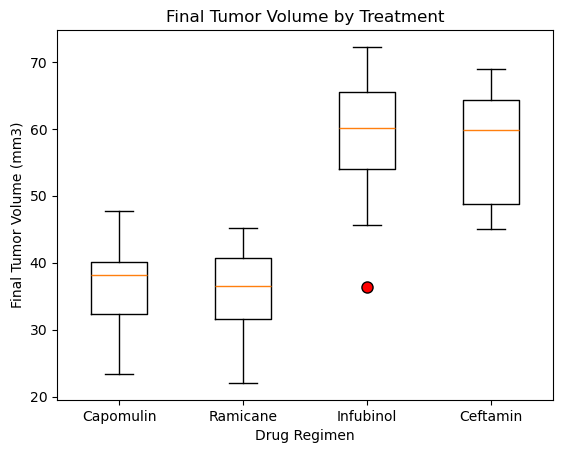

In [7]:
# 1. Create a grouped DataFrame that shows the last (greatest) time point for each mouse.
grouped_data = merged_data.groupby("Mouse ID")["Timepoint"].max()
last_timepoint_df = pd.DataFrame(grouped_data).reset_index()

# Merge this grouped DataFrame with the original cleaned DataFrame.
merged_last_timepoint = pd.merge(last_timepoint_df, merged_data, on=["Mouse ID", "Timepoint"], how="left")

# 2. Create a list that holds the treatment names.
treatment_names = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
tumor_volume_data = []

# 3. Loop through each drug in the treatment list, append the final tumor volumes for each drug.
for treatment in treatment_names:
    tumor_volume_data.append(merged_last_timepoint.loc[merged_last_timepoint["Drug Regimen"] == treatment]["Tumor Volume (mm3)"])

# 4. Determine outliers by using the upper and lower bounds, and then print the results.
for i, treatment in enumerate(treatment_names):
    quartiles = tumor_volume_data[i].quantile([0.25, 0.5, 0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    outliers = tumor_volume_data[i][(tumor_volume_data[i] < lower_bound) | (tumor_volume_data[i] > upper_bound)]
    print(f"Potential outliers for {treatment}: {outliers}")

# 5. Generate a box plot that shows the distribution of the final tumor volume for all the mice in each treatment group.
plt.boxplot(tumor_volume_data, labels=treatment_names, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title('Final Tumor Volume by Treatment')
plt.xlabel('Drug Regimen')
plt.ylabel('Final Tumor Volume (mm3)')
plt.show()

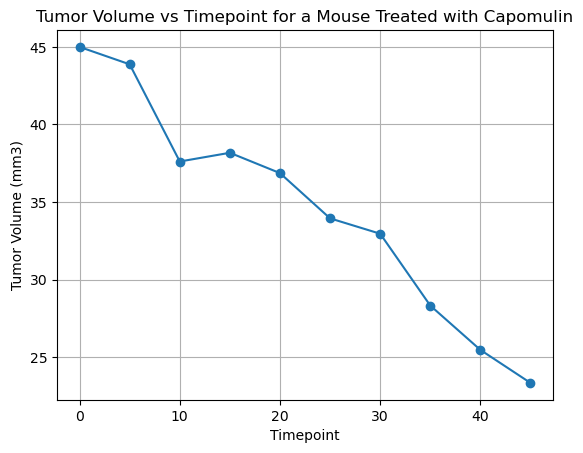

In [8]:
# Select a single mouse treated with Capomulin
capomulin_data = merged_data[merged_data["Drug Regimen"] == "Capomulin"]
single_mouse_data = capomulin_data[capomulin_data["Mouse ID"] == "s185"]

# Generate a line plot of tumor volume versus time point for the selected mouse
plt.plot(single_mouse_data["Timepoint"], single_mouse_data["Tumor Volume (mm3)"], marker='o')
plt.title("Tumor Volume vs Timepoint for a Mouse Treated with Capomulin")
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volume (mm3)")
plt.grid(True)
plt.show()

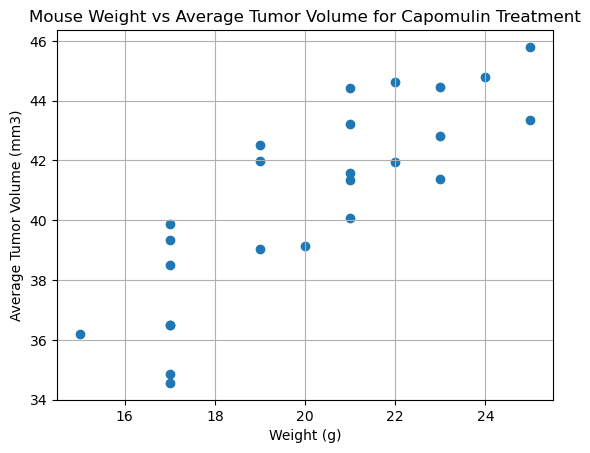

In [9]:
# Calculate the average observed tumor volume for each mouse treated with Capomulin
avg_tumor_volume = capomulin_data.groupby("Mouse ID")["Tumor Volume (mm3)"].mean()

# Merge the average tumor volume data with mouse metadata to get mouse weight
avg_tumor_volume_df = pd.DataFrame({"Mouse ID": avg_tumor_volume.index, "Average Tumor Volume (mm3)": avg_tumor_volume.values})
merged_avg_tumor_volume = pd.merge(avg_tumor_volume_df, mouse_metadata, on="Mouse ID", how="left")

# Generate a scatter plot of mouse weight versus average observed tumor volume
plt.scatter(merged_avg_tumor_volume["Weight (g)"], merged_avg_tumor_volume["Average Tumor Volume (mm3)"])
plt.title("Mouse Weight vs Average Tumor Volume for Capomulin Treatment")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.grid(True)
plt.show()

Correlation coefficient between mouse weight and average tumor volume: 0.841936342469472


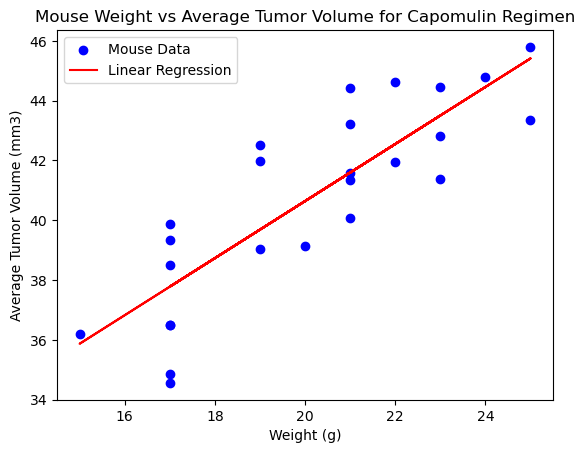

In [10]:
# Calculate average and mouse weight
mouse_weight = capomulin_data.groupby("Mouse ID")["Weight (g)"].mean()

# Generate scatter plot
plt.scatter(mouse_weight, avg_tumor_volume, color="blue", label="Mouse Data")

# Calculate correlation coefficient
correlation = pearsonr(mouse_weight, avg_tumor_volume)
print(f"Correlation coefficient between mouse weight and average tumor volume: {correlation[0]}")

# Perform linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(mouse_weight, avg_tumor_volume)
regress_values = mouse_weight * slope + intercept

# Plot linear regression line
plt.plot(mouse_weight, regress_values, "r-", label="Linear Regression")

# Add labels and title
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.title("Mouse Weight vs Average Tumor Volume for Capomulin Regimen")
plt.legend()

# Show plot
plt.show()